In [58]:
import json
import csv

import numpy as np
import pandas as pd

import seaborn as sns
print(sns.__version__)

from utils import *
%load_ext autoreload
%autoreload 2

%matplotlib inline

import unidecode
from utils import *
from tqdm import tqdm

0.7.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Convert tweet json files to csv

In [20]:
tweet_folder = '/media/storage/RawTweets/'
outpath = 'tweets_nov16_2017.csv'

tweet_folder_json_to_csv(tweet_folder, outpath)

100%|██████████| 215722/215722 [00:03<00:00, 70586.98it/s]


## Group tweets by region & filter for keywords

In [21]:
tweets_df = pd.read_csv(outpath)
regions_df = tweets_df.groupby('placename').apply(filter_tweets)
regions_df.head()

,latitude,longitude,num_tweets,physical_activity,sedentary_behavior,sleeping
placename,,,,,,
#FNLROM at Royal Ontario Museum,NaN,NaN,1.0,0.0,0.0,0.0
#Sadness,NaN,NaN,1.0,0.0,0.0,1.0
10 Dundas East,NaN,NaN,1.0,0.0,0.0,0.0
100 Bay Street South,NaN,NaN,1.0,0.0,0.0,0.0
1010 Bistro,NaN,NaN,1.0,0.0,0.0,0.0


In [38]:
regions_df.sort_values('num_tweets', ascending=False).head()

,latitude,longitude,num_tweets,physical_activity,sedentary_behavior,sleeping
placename,,,,,,
"Toronto, Ontario",43.686407,-79.383097,44754.0,354.0,1728.0,225.0
"Montréal, Québec",45.507884,-73.583789,11475.0,81.0,454.0,49.0
"Ottawa, Ontario",45.371499,-75.361060,11102.0,107.0,501.0,68.0
"Calgary, Alberta",51.039647,-114.076618,10643.0,102.0,469.0,49.0
"Vancouver, British Columbia",49.267705,-123.106493,10569.0,92.0,480.0,38.0


num_tweets            215722.0
physical_activity       2056.0
sedentary_behavior      9506.0
sleeping                1083.0
dtype: float64


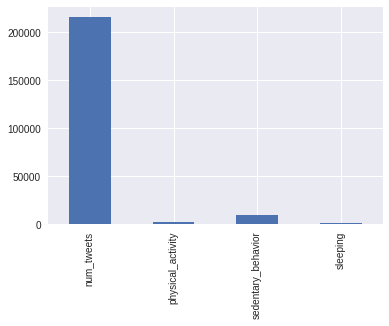

In [26]:
print(regions_df.loc[:, 'num_tweets':].sum())
regions_df.loc[:, 'num_tweets':].sum().plot(kind='bar')

## Compute geolocation for missing regions

In [ ]:
compute_geolocation_regions_geocoder(regions_df)

## Map tweets to output map

In [125]:
#%%time

mapcities_df = pd.read_csv('canadian_territories.csv')

#mapcities_df.division_name = mapcities_df.division_name.apply(unidecode.unidecode)
mapcities_df['num_tweets'] = 0
mapcities_df['physical_activity'] = 0
mapcities_df['sedentary_behavior'] = 0
mapcities_df['sleeping'] = 0

for idx in tqdm(range(len(regions_df))):
    idx_name = regions_df.index[idx]
    city_name = idx_name.split(',')[0]
    lat, long = regions_df.loc[idx_name, ['latitude', 'longitude']]
    mapped_city = mapcities_df.loc[mapcities_df.division_name == city_name]
    if not mapped_city.empty:
        city_idx = mapped_city.index.values[0]
        mapcities_df.loc[city_idx, 
                         ['num_tweets', 'physical_activity', 
                          'sedentary_behavior', 'sleeping']] += regions_df.loc[idx_name, 
                         ['num_tweets', 'physical_activity', 
                          'sedentary_behavior', 'sleeping']]        
    
    elif not pd.isnull(lat) and not pd.isnull(long):
        #print(idx_name)
        closest_idx = find_closest_city(lat, long, mapcities_df)
        mapcities_df.loc[closest_idx, 
                         ['num_tweets', 'physical_activity', 
                          'sedentary_behavior', 'sleeping']] += regions_df.loc[idx_name, 
                         ['num_tweets', 'physical_activity', 
                          'sedentary_behavior', 'sleeping']]

100%|██████████| 4098/4098 [00:30<00:00, 134.61it/s]


In [126]:
mapcities_df.head()

,province_id,province_name,division_id,division_name,latitude,longitude,num_tweets,physical_activity,sedentary_behavior,sleeping
0,46,Manitoba,4609,Division No. 9,49.972422,-98.289185,253.0,0.0,38.0,0.0
1,59,British Columbia / Colombie-Britannique,5901,East Kootenay,NaN,NaN,0.0,0.0,0.0,0.0
2,59,British Columbia / Colombie-Britannique,5933,Thompson-Nicola,50.259880,-121.407011,601.0,7.0,24.0,5.0
3,48,Alberta,4816,Division No. 16,52.147651,-106.668096,3.0,0.0,0.0,0.0
4,59,British Columbia / Colombie-Britannique,5919,Cowichan Valley,48.811745,-123.803625,81.0,3.0,6.0,0.0


In [124]:
mapcities_df.to_csv('map_output.csv', index=False)